In [5]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from tqdm import tqdm
import yaml
from utils import yaml_utils as yu

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

def load_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    return config 

def load_model(model, log_dir, iters):
    model.load_state_dict(torch.load(os.path.join(
        log_dir, 'snapshot_model_iter_{}'.format(iters)), map_location=device))



In [2]:
# PATH TO THE ROOTs OF DATASETS DIRECTORIES AND LOG DIRECTORIES
datadir_root = '/tmp'
logdir_root = '/mnt/research_logs/logs/09152022/'

# Prediction 

In [5]:
n_cond = 2

dataset_names = ['mnist', 'mnist_bg', 'mnist_bg_full', '3dshapes', 'smallNORB'][3:5]
model_names = ['neural_trans', 'neuralM', 'lstsq_rec', 'lstsq_multi', 'lstsq']
comp_errors = {}

for dataset_name in dataset_names:
    rng = np.random.RandomState(1)
    comp_errors[dataset_name] = {}
    if dataset_name == 'mnist':
        T = 20
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.5, 0.5],
            max_color_velocity_ratio=[-0.5, 0.5],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=False,
            rng=rng)
    elif dataset_name == 'mnist_bg':
        T = 20
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.5, 0.5],
            max_color_velocity_ratio=[-0.5, 0.5],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=True,
            rng=rng)
    elif dataset_name == 'mnist_bg_full':
        T = 20
        test_data = SequentialMNIST(
            datadir_root, False, T=T, max_angle_velocity_ratio=[-0.5, 0.5],
            max_color_velocity_ratio=[-0.5, 0.5],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=False,
            backgrnd=True,
            rng=rng)
    elif dataset_name == '3dshapes':
        T = 8
        test_data = ThreeDimShapesDataset(
            root=datadir_root,
            train=True, T=T,
            rng=rng)
    elif dataset_name == 'smallNORB':
        T = 6
        test_data = SmallNORBDataset(
            root=datadir_root,
            train=False,
            T=T,
            rng=rng)
    else:
        raise NotImplementedError
    n_rolls = T - n_cond
    test_loader = DataLoader(test_data, 16, True, num_workers=0)
    for model_name in model_names:
        results = []
        for seed in [1, 2, 3]: 
            path = os.path.join(logdir_root, "{}-{}-seed{}".format(dataset_name, model_name, seed))
            config = load_config(os.path.join(path, 'config.yml'))
            model = yu.load_component(config['model'])
            model.to(device)
            load_model(model, path, iters=config['max_iteration'])
            model.eval()
            losses = []
            count = 0
            with torch.no_grad():
                for images in tqdm(test_loader):
                    images = torch.stack(images).transpose(1, 0)
                    images = images.to(device)
                    images_cond, images_target = images[:, :n_cond], images[:, n_cond:n_cond+n_rolls]
                    images_pred = model(images_cond, n_rolls=n_rolls)
                    loss = torch.sum((images_target-images_pred)**2, axis=[2, 3, 4])
                    losses.append(loss.detach().cpu().numpy())
                    count +=1
            results.append(np.mean(np.concatenate(losses, 0), 0))
        comp_errors[dataset_name][model_name]= np.mean(np.stack(results), 0)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 313/313 [00:07<00:00, 42.42it/s]


(5, 5, 6, 9, 18, 96, 96)


100%|██████████| 313/313 [00:07<00:00, 42.20it/s]


In [6]:
comp_errors

{'3dshapes': {'neural_trans': array([1.7179923e+00, 3.0012558e+02, 7.2320483e+02, 1.4207731e+03,
         1.7182715e+03, 1.9064542e+03], dtype=float32),
  'neuralM': array([2.0983534e+00, 3.5423959e+02, 5.6054047e+02, 1.0460043e+03,
         1.5927919e+03, 2.1192854e+03], dtype=float32),
  'lstsq_rec': array([ 154.56404,  605.4602 , 1160.2694 , 1746.2482 , 2270.6653 ,
         2620.9482 ], dtype=float32),
  'lstsq_multi': array([ 2.8167102,  2.972785 ,  3.773885 ,  8.660385 , 20.722702 ,
         37.612995 ], dtype=float32),
  'lstsq': array([  2.7386541,   2.975114 ,   3.8812103,  24.643799 ,  27.212698 ,
         101.42679  ], dtype=float32)},
 'smallNORB': {'neural_trans': array([30.32139 , 44.26289 , 55.383026, 65.92582 ], dtype=float32),
  'neuralM': array([28.772575, 38.644344, 53.805923, 73.98205 ], dtype=float32),
  'lstsq_rec': array([ 58.252605,  84.7533  , 105.96226 , 126.334984], dtype=float32),
  'lstsq_multi': array([31.806442, 37.531826, 42.50178 , 48.74764 ], dtype=floa

mkdir: cannot create directory ‘figs’: File exists


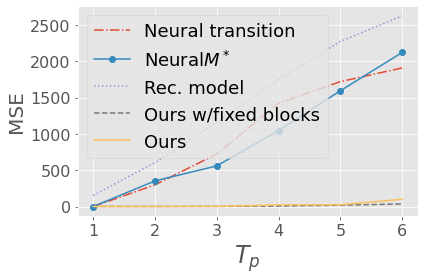

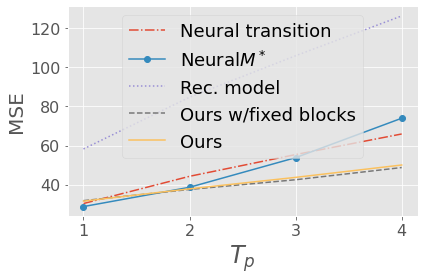

In [8]:
!mkdir figs

for dataset_name in dataset_names:
    label_name= {'neural_trans':'Neural transition', 'neuralM':'Neural$M^*$',
                'lstsq_rec':'Rec. model', 'lstsq_multi':'Ours w/fixed blocks', 'lstsq': 'Ours'}
    l_styles = ['-.', '-o', ':', '--', '-']

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    cs=colors
    plt.style.use('ggplot')
    plt.figure(figsize=[6, 4])
    for i, model_name in enumerate(model_names):
        v = comp_errors[dataset_name][model_name]
        T = len(v)
        plt.plot(np.arange(1, T+1), 
                    v,l_styles[i], label=label_name[model_name],
                    c=cs[i])
    
    if dataset_name == 'mnist':
        plt.legend(fontsize=18, loc=[0, 0])
    else:
        plt.legend(fontsize=18)    
     
    plt.xticks(np.arange(1, T+1, 1 + (T+1)//10), fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('$T_p$', fontsize=24)
    plt.ylabel('MSE', fontsize=20)
    plt.tight_layout()
    plt.savefig('figs/comp_error_{}.pdf'.format(dataset_name))


In [6]:
n_cond = 5

dataset_names = ['mnist_accl']
model_names = ['neural_trans', 'lstsq', 'holstsq']
comp_errors = {}

for dataset_name in dataset_names:
    rng = np.random.RandomState(1)
    comp_errors[dataset_name] = {}
    if dataset_name == 'mnist_accl':
        T = 20
        test_data = SequentialMNIST(
            datadir_root, False, T=T,         
            max_angle_velocity_ratio=[-0.2, 0.2],
            max_angle_accl_ratio=[-0.025, 0.025],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_color_accl_ratio=[-0.025, 0.025],
            max_pos=[-0, 0.],
            max_trans_accl=[0.0, 0.0],
            max_T=T,
            only_use_digit4=True,
            backgrnd=False,
            rng=rng)
    else:
        raise NotImplementedError
    n_rolls = T - n_cond
    test_loader = DataLoader(test_data, 16, True, num_workers=0)
    images = iter(test_loader).next()
    images = torch.stack(images).transpose(1, 0)
    images = images.to(device)
    for model_name in model_names:
        results = []
        for seed in [1, 2, 3]: 
            path = os.path.join(logdir_root, "{}-{}-seed{}".format(dataset_name, model_name, seed))
            config = load_config(os.path.join(path, 'config.yml'))
            model = yu.load_component(config['model'])
            model.to(device)
            load_model(model, path, iters=config['max_iteration'])
            model.eval()
            losses = []
            count = 0
            with torch.no_grad():
                for images in tqdm(test_loader):
                    images = torch.stack(images).transpose(1, 0)
                    images = images.to(device)
                    images_cond, images_target = images[:, :n_cond], images[:, n_cond:n_cond+n_rolls]
                    images_pred = model(images_cond, n_rolls=n_rolls)
                    loss = torch.sum((images_target-images_pred)**2, axis=[2, 3, 4])
                    losses.append(loss.detach().cpu().numpy())
                    count +=1
            results.append(np.mean(np.concatenate(losses, 0), 0))
        comp_errors[dataset_name][model_name]= np.mean(np.stack(results), 0)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


mkdir: cannot create directory ‘figs’: File exists


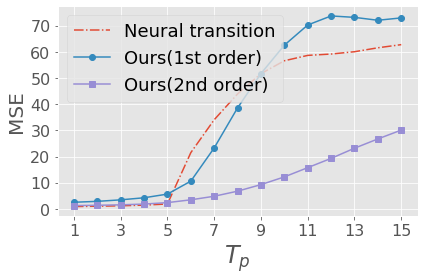

In [9]:
!mkdir figs
for dataset_name in dataset_names:
    label_name= {'neural_trans':'Neural transition', 'lstsq':'Ours(1st order)', 'holstsq': 'Ours(2nd order)', }
    l_styles = ['-.', '-o', '-s']

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    cs=colors
    plt.style.use('ggplot')
    plt.figure(figsize=[6, 4])
    for i, model_name in enumerate(model_names):
        v = comp_errors[dataset_name][model_name]
        T = len(v)
        plt.plot(np.arange(1, T+1), 
                    v,l_styles[i], label=label_name[model_name],
                    c=cs[i])

    plt.legend(fontsize=18)        
    plt.xticks(np.arange(1, T+1, 1 + (T+1)//10), fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('$T_p$', fontsize=24)
    plt.ylabel('MSE', fontsize=20)
    plt.tight_layout()
    plt.savefig('figs/comp_error_{}.pdf'.format(dataset_name))
